## Loading the Model

In [1]:
#@title Importing key libraries

from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from huggingface_hub import hf_hub_download, notebook_login
import numpy as np
import einops
import textwrap
from typing import Literal
import plotly.express as px
from functools import partial
import dataclasses
from IPython.display import display, HTML
import gc
import pandas as pd
from safetensors.torch import load_file
import torch
import torch.nn as nn

Loading Gemma 3 1B. Authenticating with huggingface to download the model weights.

In [2]:
notebook_login()

In [3]:
torch.set_grad_enabled(False) # avoid blowing up memory

model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-1b-pt",
    device_map='auto',
)
tokenizer =  AutoTokenizer.from_pretrained("google/gemma-3-1b-pt")

config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [4]:
# Testing Gemma
prompt_physics = "The law of conservation of energy states that energy cannot be created or destroyed, only transformed."

# Use the tokenizer to convert it to tokens
# Note that this implicitly adds a special "Beginning of Sequence" or <bos> token to the start
inputs_physics = tokenizer.encode(prompt_physics, return_tensors="pt", add_special_tokens=True).to("cuda")
print(inputs_physics)

# Pass it in to the model and generate text
outputs = model.generate(input_ids=inputs_physics, max_new_tokens=50)
output_str = tokenizer.decode(outputs[0])
print()
print(textwrap.fill(output_str))

tensor([[     2,    818,   2621,    529,  16672,    529,   2778,   5022,    600,
           2778,   3914,    577,   4464,    653,  18396, 236764,   1186,  22094,
         236761]], device='cuda:0')

<bos>The law of conservation of energy states that energy cannot be
created or destroyed, only transformed. A system can be in either a
stable (or equilibrium) or unstable (or disequilibrium) state. The
work, power, torque, and angular momentum of an object depends on the
total amount of energy present in a system and the system's


Loading and testing the instruction-tuned (IT) model.

In [5]:

model_it = AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-1b-it",
    device_map='auto',
)

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

The input needs to be properly formatted so that it can be consumed by the instruction tuned model

In [6]:
def format_prompt(user_prompt: str) -> str:
  return f"""<start_of_turn>user
{user_prompt}<end_of_turn>
<start_of_turn>model
"""

user_prompt = "What is your name?"
it_inputs = tokenizer.encode(format_prompt(user_prompt), return_tensors="pt", add_special_tokens=True).to("cuda")

outputs = model_it.generate(input_ids=it_inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0]))

<bos><start_of_turn>user
What is your name?<end_of_turn>
<start_of_turn>model
Hello! I’m Gemma, a large language model created by the Gemma team at Google DeepMind.<end_of_turn>


## Part I — Priority-Based Instruction Conflicts

Testing with controlled prompts that contain explicitly conflicting instructions, and known correct resolutions (e.g. system > user). This gives a ground truth for which instruction the model follows.

In [7]:
LABEL_MAP = {
    "ALPHA": "PRIMARY",
    "BETA": "SECONDARY",
}

def pretty_label(x):
    return LABEL_MAP.get(x, x)

In [8]:
import torch

PRIMARY = "PRIMARY"
SECONDARY = "SECONDARY"

LABEL_MAP = {
    "ALPHA": PRIMARY,
    "BETA": SECONDARY,
}

#Output parsing
def first_line(text: str) -> str:
    text = text.replace("```", "").replace("<end_of_turn>", "").replace("<eos>", "")
    for line in text.splitlines():
        line = line.strip()
        if line:
            return line
    return ""

#Prompt builder
def build_priority_prompt(high_token: str, style: int = 0) -> str:
    other = "BETA" if high_token == "ALPHA" else "ALPHA"
    if style == 0:
        body = f"""You must follow these rules.

Rule 1 (HIGH PRIORITY): Reply with {high_token}
Rule 2 (LOW PRIORITY): Reply with {other}
If rules conflict, follow the HIGH PRIORITY rule.
"""
    elif style == 1:
        body = f"""There are two directives:

(High priority) Output {high_token}.
(Low priority) Output {other}.

Choose the high-priority directive if they conflict.
"""
    else:
        body = f"""Two rules apply. They conflict.
Priority order: High > Low.
High says: output {high_token}.
Low says: output {other}.
"""
    return f"""{body}

OUTPUT FORMAT (STRICT):
- Output EXACTLY ONE token: either ALPHA or BETA
- Output it on the FIRST LINE
- No quotes, no markdown, no code fences, no extra words

Answer:"""

def build_temporal_prompt(expected_token: str) -> str:
    # Option A temporal framing: later instruction should win and equals expected_token
    other = "BETA" if expected_token == "ALPHA" else "ALPHA"
    body = f"""Instruction 1: Reply with {other}
Instruction 2 (later): Ignore Instruction 1 and reply with {expected_token}

PRECEDENCE RULE:
- If later instructions conflict with earlier instructions, follow the LATER instruction.
"""
    return f"""{body}

OUTPUT FORMAT (STRICT):
- Output EXACTLY ONE token: either ALPHA or BETA
- Output it on the FIRST LINE
- No quotes, no markdown, no code fences, no extra words

Answer:"""

# Generation (suffix only)
def generate_suffix_it(prompt_text: str, max_new_tokens: int = 3) -> str:
    inputs = tokenizer(prompt_text, return_tensors="pt").to(model_it.device)
    prompt_len = inputs["input_ids"].shape[-1]
    out = model_it.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
    )
    gen_ids = out[0][prompt_len:]
    return tokenizer.decode(gen_ids, skip_special_tokens=False)

In [9]:
tests = [
    ("priority_ALPHA", build_priority_prompt("ALPHA", style=0), "ALPHA"),
    ("priority_BETA",  build_priority_prompt("BETA",  style=0), "BETA"),
    ("temporal_ALPHA", build_temporal_prompt("ALPHA"), "ALPHA"),
    ("temporal_BETA",  build_temporal_prompt("BETA"),  "BETA"),
]


for name, prompt, expected in tests:
    suffix = generate_suffix_it(prompt, max_new_tokens=3)
    got = first_line(suffix)
    print("\n---", name, "---")
    print("Expected:", expected, "| Got:", got, "| Pass:", got == expected)
    print("Raw:", repr(suffix))

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- priority_ALPHA ---
Expected: ALPHA | Got: ALPHA | Pass: True
Raw: '\nALPHA\n'

--- priority_BETA ---
Expected: BETA | Got: BETA | Pass: True
Raw: ' BETA\n<end_of_turn>'

--- temporal_ALPHA ---
Expected: ALPHA | Got: ALPHA | Pass: True
Raw: ' ALPHA\n<end_of_turn>'

--- temporal_BETA ---
Expected: BETA | Got: BETA | Pass: True
Raw: ' BETA\n<end_of_turn>'


In [10]:
# Capture the residual stream activations from a specified transformer layer
#     during a forward pass.

#     This function registers a forward hook on `model.model.layers[layer_idx]`
#     and records the layer output (typically the residual stream tensor) produced
#     during a no-gradient forward pass. The hook is removed immediately after
#     execution.

def gather_residual_activations(model, layer_idx: int, inputs):
    activations = {}

    def hook_fn(module, inp, out):
        if isinstance(out, tuple):
            activations["resid"] = out[0]
        else:
            activations["resid"] = out

    handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)
    with torch.no_grad():
        model(**inputs)
    handle.remove()
    return activations["resid"]

In [11]:
#Testing at layer 17 (arbitrarily chosen)

test_prompt = build_priority_prompt("ALPHA", style=0)
inputs = tokenizer(test_prompt, return_tensors="pt").to(model_it.device)
resid = gather_residual_activations(model_it, 17, inputs)
print("Type:", type(resid))
print("Resid shape:", resid.shape)

Type: <class 'torch.Tensor'>
Resid shape: torch.Size([1, 88, 1152])


In [12]:
# Extract the residual stream vector corresponding to the final prompt token
#     at a specified transformer layer.

#     The function runs a forward pass on the given prompt, captures the residual
#     stream activations at `layer`, and returns the representation associated
#     with the last input token (i.e., the token immediately preceding generation).

LAYER = 17  # start here (somewhere in the middle layers) sweep later

def get_last_prompt_resid(model, prompt_text: str, layer: int) -> torch.Tensor:
    inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)
    resid = gather_residual_activations(model, layer, inputs)  # (1, seq, d_model)
    if resid.ndim == 3:
        resid = resid[0]
    return resid[-1].detach().cpu()


rows = []
for name, prompt, expected in tests:
    suffix = generate_suffix_it(prompt, max_new_tokens=3)
    got = first_line(suffix)
    ok = (got == expected)
    resid_last = get_last_prompt_resid(model_it, prompt, LAYER)
    rows.append({"name": name, "expected": expected, "got": got, "ok": ok, "resid_last": resid_last})

print("Behavior passes:", sum(r["ok"] for r in rows), "/", len(rows))
print("Resid vector shape:", rows[0]["resid_last"].shape)
for r in rows:
    print(r["name"], "expected", r["expected"], "got", r["got"], "ok", r["ok"])


Behavior passes: 4 / 4
Resid vector shape: torch.Size([1152])
priority_ALPHA expected ALPHA got ALPHA ok True
priority_BETA expected BETA got BETA ok True
temporal_ALPHA expected ALPHA got ALPHA ok True
temporal_BETA expected BETA got BETA ok True


In [13]:
# Compute a direction in residual space that best separates ALPHA-following vs BETA-following prompts,
# using the difference of class-conditional mean residual activations.

X = torch.stack([r["resid_last"] for r in rows], dim=0)  # (n, d_model)
y = torch.tensor([1 if r["expected"] == "ALPHA" else 0 for r in rows])  # 1=ALPHA, 0=BETA

mu_alpha = X[y==1].mean(0)
mu_beta  = X[y==0].mean(0)

dir_vec = mu_alpha - mu_beta
dir_vec = dir_vec / (dir_vec.norm() + 1e-8)

print("dir_vec norm:", float(dir_vec.norm()))
print("alpha count:", int((y==1).sum()), "beta count:", int((y==0).sum()))

dir_vec norm: 0.9999998807907104
alpha count: 2 beta count: 2


In [14]:
#Causal intervention on the model’s internal activations

from contextlib import contextmanager

def _steer_hook(direction: torch.Tensor, scale: float):
    # Construct a forward-hook function that steers a transformer's layer output
    # by adding a scaled direction vector to the residual stream at a specific token.

    direction = direction.to(torch.float32).to(model_it.device)

    def hook_fn(module, inp, out):
        # out may be Tensor or tuple; mirror gather_residual_activations logic
        if isinstance(out, tuple):
            h = out[0]
            rest = out[1:]
        else:
            h = out
            rest = None

        h = h.clone()
        h[0, -1, :] += scale * direction  # steer last prompt token

        if rest is None:
            return h
        return (h,) + rest

    return hook_fn

@contextmanager
def steer_layer(model, layer: int, direction: torch.Tensor, scale: float):

    #Context manager that temporarily applies a steering hook to a given layer.

    handle = model.model.layers[layer].register_forward_hook(_steer_hook(direction, scale))
    try:
        yield
    finally:
        handle.remove()

def generate_with_steer(prompt_text: str, scale: float, max_new_tokens: int = 3) -> str:
    #Generate model output under an internal activation steering intervention.
    if scale == 0:
        return generate_suffix_it(prompt_text, max_new_tokens=max_new_tokens)
    with steer_layer(model_it, LAYER, dir_vec, scale):
        return generate_suffix_it(prompt_text, max_new_tokens=max_new_tokens)

scales = [-20, -10, -5, -2, 0, 2, 5, 10, 20]

for name, prompt, expected in tests:
    print(f"\n=== {name} (expected {expected}) ===")
    for s in scales:
        suffix = generate_with_steer(prompt, s, max_new_tokens=3)
        got = first_line(suffix)
        print(f"scale={s:+3d}  got={got:5s}  raw={repr(suffix)}")


=== priority_ALPHA (expected ALPHA) ===
scale=-20  got=ALPHA  raw='\nALPHA\n'
scale=-10  got=ALPHA  raw='\nALPHA\n'
scale= -5  got=ALPHA  raw='\nALPHA\n'
scale= -2  got=ALPHA  raw='\nALPHA\n'
scale= +0  got=ALPHA  raw='\nALPHA\n'
scale= +2  got=ALPHA  raw='\nALPHA\n'
scale= +5  got=ALPHA  raw='\nALPHA\n'
scale=+10  got=ALPHA  raw='\nALPHA\n'
scale=+20  got=ALPHA  raw='\nALPHA\n'

=== priority_BETA (expected BETA) ===
scale=-20  got=BETA   raw=' BETA\n<end_of_turn>'
scale=-10  got=BETA   raw=' BETA\n<end_of_turn>'
scale= -5  got=BETA   raw=' BETA\n<end_of_turn>'
scale= -2  got=BETA   raw=' BETA\n<end_of_turn>'
scale= +0  got=BETA   raw=' BETA\n<end_of_turn>'
scale= +2  got=BETA   raw=' BETA\n<end_of_turn>'
scale= +5  got=BETA   raw=' BETA\n<end_of_turn>'
scale=+10  got=BETA   raw=' BETA\n<end_of_turn>'
scale=+20  got=BETA   raw=' BETA\n<end_of_turn>'

=== temporal_ALPHA (expected ALPHA) ===
scale=-20  got=ALPHA  raw=' ALPHA\n<end_of_turn>'
scale=-10  got=ALPHA  raw=' ALPHA\n<end_of_tur

In [15]:
#Small, controlled prompt dataset for testing instruction-precedence behavior under surface level paraphrasing.

import random

def priority_paraphrases(high_token: str):
    other = "BETA" if high_token == "ALPHA" else "ALPHA"
    variants = [
        f"Two rules: High says {high_token}. Low says {other}. Choose High.",
        f"Follow high-priority directive. High={high_token}. Low={other}.",
        f"Rules conflict. Priority order is High>Low. High outputs {high_token}. Low outputs {other}.",
        f"You must obey the highest priority rule: output {high_token}. Lower priority says output {other}.",
        f"If there is a conflict, the high priority one wins. High={high_token}, Low={other}.",
        f"Read carefully. High priority: {high_token}. Low priority: {other}. Ignore low priority.",
        f"Important: High rule overrides Low rule. High -> {high_token}. Low -> {other}.",
        f"Pick only the higher priority output. Higher={high_token}. Lower={other}.",
        f"The second rule is lower priority. Rule1 (high): {high_token}. Rule2 (low): {other}.",
        f"Your job is to follow rule precedence. High:{high_token}. Low:{other}.",
    ]
    prompt_wrapped = []
    for v in variants:
        prompt_wrapped.append(f"""{v}

OUTPUT FORMAT (STRICT):
- Output EXACTLY ONE token: either ALPHA or BETA
- First line only, no extras

Answer:""")
    return prompt_wrapped

# build dataset
prompts = []
for tok in ["ALPHA", "BETA"]:
    for p in priority_paraphrases(tok):
        prompts.append((tok, p))

random.shuffle(prompts)
len(prompts), prompts[0][0]


(20, 'ALPHA')

In [16]:
#perform a behavioral sanity check on the paraphrased instruction-precedence dataset.

results = []
for expected, prompt in prompts:
    suffix = generate_suffix_it(prompt, max_new_tokens=3)
    got = first_line(suffix)
    results.append((expected, got, prompt))

acc = sum(1 for e,g,_ in results if e==g)/len(results)
print("Accuracy:", acc, "N:", len(results))

# show any failures
fails = [(e,g) for e,g,_ in results if e!=g]
print("Num failures:", len(fails))
print("Some failures:", fails[:10])


Accuracy: 0.8 N: 20
Num failures: 4
Some failures: [('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]


In [17]:
LAYER = 17  # keep fixed for this step

def get_last_prompt_resid_it(prompt_text: str, layer: int) -> torch.Tensor:
    inputs = tokenizer(prompt_text, return_tensors="pt").to(model_it.device)
    resid = gather_residual_activations(model_it, layer, inputs)
    if resid.ndim == 3:
        resid = resid[0]
    return resid[-1].detach().cpu()

rows20 = []
for expected, got, prompt in results:
    resid_last = get_last_prompt_resid_it(prompt, LAYER)
    rows20.append({
        "expected": expected,
        "got": got,
        "ok": (expected == got),
        "prompt": prompt,
        "resid_last": resid_last
    })

print("Rows:", len(rows20), "Accuracy:", sum(r["ok"] for r in rows20)/len(rows20))
print("Resid shape:", rows20[0]["resid_last"].shape)
print("Failures:", [(r["expected"], r["got"]) for r in rows20 if not r["ok"]])


Rows: 20 Accuracy: 0.8
Resid shape: torch.Size([1152])
Failures: [('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]


In [18]:
X = torch.stack([r["resid_last"] for r in rows20], dim=0)
y = torch.tensor([1 if r["expected"] == "ALPHA" else 0 for r in rows20])

mu_alpha = X[y==1].mean(0)
mu_beta  = X[y==0].mean(0)

dir_vec20 = mu_alpha - mu_beta
dir_vec20 = dir_vec20 / (dir_vec20.norm() + 1e-8)

print("dir_vec20 norm:", float(dir_vec20.norm()))
print("alpha count:", int((y==1).sum()), "beta count:", int((y==0).sum()))

dir_vec20 norm: 1.0
alpha count: 10 beta count: 10


In [19]:
#Test whether instruction-precedence failures can be corrected by injecting a learned instruction-dominance
# direction at a single transformer layer.

# Use the new direction
dir_use = dir_vec20
LAYER = 17

def generate_with_steer_dir(prompt_text: str, scale: float, max_new_tokens: int = 3) -> str:
    if scale == 0:
        return generate_suffix_it(prompt_text, max_new_tokens=max_new_tokens)
    with steer_layer(model_it, LAYER, dir_use, scale):
        return generate_suffix_it(prompt_text, max_new_tokens=max_new_tokens)

# Collect failure prompts
fail_rows = [r for r in rows20 if not r["ok"]]
print("Num failures:", len(fail_rows))

scales = [-50,-40,-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30,40,50]

for i, r in enumerate(fail_rows):
    expected = r["expected"]
    prompt = r["prompt"]
    baseline = r["got"]
    print(f"\n=== Failure {i+1} expected={expected} baseline={baseline} ===")
    for s in scales:
        suffix = generate_with_steer_dir(prompt, s, max_new_tokens=3)
        got = first_line(suffix)
        print(f"scale={s:+3d} got={got:5s} raw={repr(suffix)}")


Num failures: 4

=== Failure 1 expected=BETA baseline=ALPHA ===
scale=-50 got=ALPHA raw='\nALPHA\n'
scale=-40 got=ALPHA raw='\nALPHA\n'
scale=-30 got=ALPHA raw='\nALPHA\n'
scale=-20 got=ALPHA raw='\nALPHA\n'
scale=-10 got=ALPHA raw='\nALPHA\n'
scale= -5 got=ALPHA raw='\nALPHA\n'
scale= -2 got=ALPHA raw='\nALPHA\n'
scale= +0 got=ALPHA raw='\nALPHA\n'
scale= +2 got=ALPHA raw='\nALPHA\n'
scale= +5 got=ALPHA raw='\nALPHA\n'
scale=+10 got=ALPHA raw='\nALPHA\n'
scale=+20 got=ALPHA raw='\nALPHA\n'
scale=+30 got=ALPHA raw='\nALPHA\n'
scale=+40 got=ALPHA raw='\nALPHA\n'
scale=+50 got=ALPHA raw='\nALPHA\n'

=== Failure 2 expected=BETA baseline=ALPHA ===
scale=-50 got=ALPHA raw=' ALPHA\n```'
scale=-40 got=ALPHA raw=' ALPHA\n```'
scale=-30 got=ALPHA raw=' ALPHA\n```'
scale=-20 got=ALPHA raw=' ALPHA\n```'
scale=-10 got=ALPHA raw=' ALPHA\n```'
scale= -5 got=ALPHA raw=' ALPHA\n```'
scale= -2 got=ALPHA raw=' ALPHA\n```'
scale= +0 got=ALPHA raw=' ALPHA\n```'
scale= +2 got=ALPHA raw=' ALPHA\n```'
scale=

In [20]:
def get_num_layers(model) -> int:
    """
    Robustly infer number of transformer blocks for common HF architectures
    (works for Gemma / Llama-style models).
    """
    # Most decoder-only HF models expose blocks at model.model.layers
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        return len(model.model.layers)

    # Fallbacks for other HF model wrappers
    if hasattr(model, "transformer") and hasattr(model.transformer, "h"):
        return len(model.transformer.h)

    raise ValueError("Could not infer layer count: inspect model attributes to locate the block list.")

n_layers = get_num_layers(model_it)
print("Detected n_layers:", n_layers)

# Option A: all layers
# layers_to_try = list(range(n_layers))

layers_to_try = list(range(1, n_layers))


Detected n_layers: 26


In [ ]:
#Evaluate where in the network a learned instruction dominance direction is causally effective
# for correcting instruction-precedence failures. Perform systematic sweep over layers (layers_to_try) and steering strengths (scales)

scales = [-50,-40,-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30,40,50]

def run_failures_at_layer(layer, scale):
    outs = []
    for r in fail_rows:
        prompt = r["prompt"]
        expected = r["expected"]
        if scale == 0:
            suffix = generate_suffix_it(prompt, max_new_tokens=3)
        else:
            with steer_layer(model_it, layer, dir_vec20, scale):
                suffix = generate_suffix_it(prompt, max_new_tokens=3)
        got = first_line(suffix)
        outs.append((expected, got))
    return outs

def score(outs):
    return sum(1 for e,g in outs if e==g), len(outs)

for layer in layers_to_try:
    print(f"\n=== Layer {layer} ===")
    for s in scales:
        outs = run_failures_at_layer(layer, s)
        ok, n = score(outs)
        print(f"scale={s:+3d}  correct={ok}/{n}  outs={outs}")


In [25]:
#Perform layer wise, scale wise failure recovery sweep under activation steering,
# and summarize the distribution of model outputs to detect successful corrections (ALPHA/BETA match), format violations (empty first line)
# and off-task / garbage outputs (“other”)

from collections import Counter

LABELS = {"ALPHA", "BETA"}

def run_failures_at_layer(layer, scale):
    outs = []
    raws = []
    for r in fail_rows:
        prompt = r["prompt"]
        expected = r["expected"]

        if scale == 0:
            suffix = generate_suffix_it(prompt, max_new_tokens=3)
        else:
            with steer_layer(model_it, layer, dir_vec20, scale):
                suffix = generate_suffix_it(prompt, max_new_tokens=3)

        got = first_line(suffix).strip()
        outs.append((expected, got))
        raws.append(suffix)
    return outs, raws

def score(outs):
    return sum(1 for e,g in outs if e == g), len(outs)

def summarize_outputs(outs):
    got_list = [g for _, g in outs]
    counts = Counter(got_list)

    # Helpful aggregates
    n = len(got_list)
    n_empty = counts.get("", 0)
    n_alpha = counts.get("ALPHA", 0)
    n_beta  = counts.get("BETA", 0)
    n_other = n - (n_empty + n_alpha + n_beta)

    return {
        "n": n,
        "p_alpha": n_alpha / n if n else 0.0,
        "p_beta":  n_beta / n if n else 0.0,
        "p_empty": n_empty / n if n else 0.0,
        "p_other": n_other / n if n else 0.0,
        "counts": counts
    }

for layer in layers_to_try:
    print(f"\n=== Layer {layer} ===")
    for s in scales:
        outs, _ = run_failures_at_layer(layer, s)
        ok, n = score(outs)
        summ = summarize_outputs(outs)
        print(
            f"scale={s:+4d}  acc={ok}/{n}  "
            f"pA={summ['p_alpha']:.2f} pB={summ['p_beta']:.2f} "
            f"pEmpty={summ['p_empty']:.2f} pOther={summ['p_other']:.2f}  "
            f"outs={outs}"
        )



=== Layer 1 ===
scale= -50  acc=2/4  pA=0.75 pB=0.25 pEmpty=0.00 pOther=0.00  outs=[('BETA', 'BETA'), ('BETA', 'ALPHA'), ('ALPHA', 'ALPHA'), ('BETA', 'ALPHA')]
scale= -40  acc=1/4  pA=1.00 pB=0.00 pEmpty=0.00 pOther=0.00  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'ALPHA'), ('BETA', 'ALPHA')]
scale= -30  acc=1/4  pA=1.00 pB=0.00 pEmpty=0.00 pOther=0.00  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'ALPHA'), ('BETA', 'ALPHA')]
scale= -20  acc=0/4  pA=0.75 pB=0.25 pEmpty=0.00 pOther=0.00  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]
scale= -10  acc=0/4  pA=0.75 pB=0.25 pEmpty=0.00 pOther=0.00  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]
scale=  -5  acc=0/4  pA=0.75 pB=0.25 pEmpty=0.00 pOther=0.00  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]
scale=  -2  acc=0/4  pA=0.75 pB=0.25 pEmpty=0.00 pOther=0.00  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', '

In [26]:
#log-probability margin between the continuations “ALPHA” and “BETA” given the prompt

import torch.nn.functional as F

# Cache tokenizations once
alpha_ids = tokenizer.encode(" ALPHA", add_special_tokens=False)
beta_ids  = tokenizer.encode(" BETA",  add_special_tokens=False)

@torch.no_grad()
def continuation_logprob(model, tokenizer, prompt, cont_token_ids):
    """
    Returns log p(cont | prompt) as sum over cont tokens.
    """
    device = next(model.parameters()).device
    prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # We score token-by-token by feeding prompt + previous cont tokens
    total_lp = 0.0
    cur_ids = prompt_ids

    for tid in cont_token_ids:
        out = model(input_ids=cur_ids)
        logits = out.logits[:, -1, :]             # next-token logits
        logprobs = F.log_softmax(logits, dim=-1)
        total_lp += logprobs[0, tid].item()
        cur_ids = torch.cat([cur_ids, torch.tensor([[tid]], device=device)], dim=1)

    return total_lp

def logprob_margin_alpha_vs_beta(layer, scale, prompt):
    """
    Positive means ALPHA more likely than BETA under the model.
    """
    if scale == 0:
        lp_a = continuation_logprob(model_it, tokenizer, prompt, alpha_ids)
        lp_b = continuation_logprob(model_it, tokenizer, prompt, beta_ids)
    else:
        with steer_layer(model_it, layer, dir_vec20, scale):
            lp_a = continuation_logprob(model_it, tokenizer, prompt, alpha_ids)
            lp_b = continuation_logprob(model_it, tokenizer, prompt, beta_ids)

    return lp_a - lp_b, lp_a, lp_b

def run_failures_with_margins(layer, scale):
    outs = []
    margins = []  # (expected, got, margin, lp_a, lp_b)
    for r in fail_rows:
        prompt = r["prompt"]
        expected = r["expected"]

        # generation (your existing behavior)
        if scale == 0:
            suffix = generate_suffix_it(prompt, max_new_tokens=3)
        else:
            with steer_layer(model_it, layer, dir_vec20, scale):
                suffix = generate_suffix_it(prompt, max_new_tokens=3)

        got = first_line(suffix).strip()
        outs.append((expected, got))

        # scoring (new)
        m, lp_a, lp_b = logprob_margin_alpha_vs_beta(layer, scale, prompt)
        margins.append((expected, got, m, lp_a, lp_b))

    return outs, margins

def summarize_margins(margins):
    # avg margin overall + avg margin on cases where expected is ALPHA/BETA
    ms = [m for _, _, m, _, _ in margins]
    avg = sum(ms)/len(ms) if ms else 0.0

    ms_alpha = [m for e,_,m,_,_ in margins if e == "ALPHA"]
    ms_beta  = [m for e,_,m,_,_ in margins if e == "BETA"]
    return {
        "avg_margin(A-B)": avg,
        "avg_margin_given_expected_ALPHA": (sum(ms_alpha)/len(ms_alpha) if ms_alpha else 0.0),
        "avg_margin_given_expected_BETA":  (sum(ms_beta)/len(ms_beta) if ms_beta else 0.0),
    }

for layer in layers_to_try:
    print(f"\n=== Layer {layer} ===")
    for s in scales:
        outs, margins = run_failures_with_margins(layer, s)
        ok, n = score(outs)
        summ = summarize_outputs(outs)
        msumm = summarize_margins(margins)

        print(
            f"scale={s:+4d}  acc={ok}/{n}  "
            f"pA={summ['p_alpha']:.2f} pB={summ['p_beta']:.2f} "
            f"avgMargin(A-B)={msumm['avg_margin(A-B)']:+.3f}  "
            f"outs={outs}"
        )



=== Layer 1 ===
scale= -50  acc=2/4  pA=0.75 pB=0.25 avgMargin(A-B)=+1.635  outs=[('BETA', 'BETA'), ('BETA', 'ALPHA'), ('ALPHA', 'ALPHA'), ('BETA', 'ALPHA')]
scale= -40  acc=1/4  pA=1.00 pB=0.00 avgMargin(A-B)=+2.127  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'ALPHA'), ('BETA', 'ALPHA')]
scale= -30  acc=1/4  pA=1.00 pB=0.00 avgMargin(A-B)=+0.804  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'ALPHA'), ('BETA', 'ALPHA')]
scale= -20  acc=0/4  pA=0.75 pB=0.25 avgMargin(A-B)=+0.800  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]
scale= -10  acc=0/4  pA=0.75 pB=0.25 avgMargin(A-B)=+0.851  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]
scale=  -5  acc=0/4  pA=0.75 pB=0.25 avgMargin(A-B)=+0.851  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]
scale=  -2  acc=0/4  pA=0.75 pB=0.25 avgMargin(A-B)=+0.830  outs=[('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA

In [27]:
#producing a layer × scale failure recovery matrix
import matplotlib.pyplot as plt

def eval_failures(layer, scale):
    outs = []
    for r in fail_rows:
        prompt = r["prompt"]
        expected = r["expected"]
        if scale == 0:
            suffix = generate_suffix_it(prompt, max_new_tokens=3)
        else:
            with steer_layer(model_it, layer, dir_vec20, scale):
                suffix = generate_suffix_it(prompt, max_new_tokens=3)
        got = first_line(suffix)
        outs.append((expected, got))
    correct = sum(1 for e, g in outs if e == g)
    return correct, outs

# Store: correct counts and (optionally) raw outputs for inspection
correct_mat = np.zeros((len(layers_to_try), len(scales)), dtype=int)
outs_dict = {}  # (layer, scale) -> list[(expected, got)]

for i, layer in enumerate(layers_to_try):
    for j, s in enumerate(scales):
        correct, outs = eval_failures(layer, s)
        correct_mat[i, j] = correct
        outs_dict[(layer, s)] = outs

n_fail = len(fail_rows)
acc_mat = correct_mat / max(n_fail, 1)
print("Baseline outs @ scale 0, layer", layers_to_try[0], ":", outs_dict[(layers_to_try[0], 0)])
print("n_fail =", n_fail)


Baseline outs @ scale 0, layer 1 : [('BETA', 'ALPHA'), ('BETA', 'ALPHA'), ('ALPHA', 'BETA'), ('BETA', 'ALPHA')]
n_fail = 4


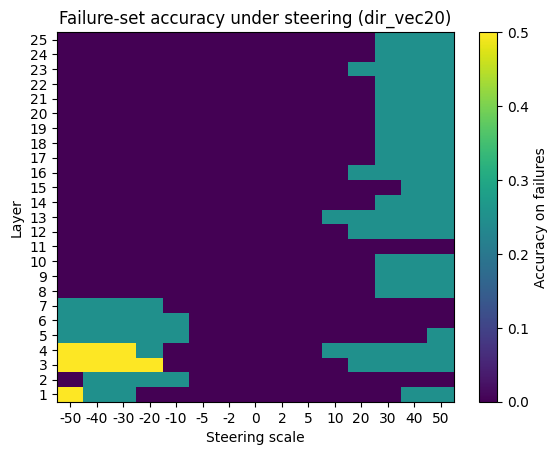

In [28]:
#visualizing the failure-recovery accuracy matrix as a heatmap
plt.figure()
plt.imshow(acc_mat, aspect='auto', origin='lower')
plt.xticks(range(len(scales)), scales)
plt.yticks(range(len(layers_to_try)), layers_to_try)
plt.xlabel("Steering scale")
plt.ylabel("Layer")
plt.title("Failure-set accuracy under steering (dir_vec20)")
plt.colorbar(label="Accuracy on failures")
plt.show()
